# Exercice : dose map analysis

## Initialisation

Import modules. 
- matplotlib for plot
- numpy for matrix/vector numerical computation
- SimpleITK for image manipulation
- interact for slider

http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from ipywidgets import interact
# to enable interactive widgets in jupyter notebook run this command in a terminal:
#jupyter nbextension enable --py widgetsnbextension

In [2]:
# Read a sitk image
img_ct = sitk.ReadImage('../data/patient-2mm.mhd')
print('Image size: ', img_ct.GetSize())
print('Image spacing: ', img_ct.GetSpacing())
print('Image origin: ', img_ct.GetOrigin())

Image size:  (126, 126, 111)
Image spacing:  (2.0, 2.0, 2.0)
Image origin:  (0.0, 0.0, 0.0)


In [3]:
# Convert sitk image to a numpy array
arr_ct = sitk.GetArrayFromImage(img_ct)
print('Array size: ', arr_ct.shape, ' <--- be careful to the dimension order!)')

Array size:  (111, 126, 126)  <--- be careful to the dimension order!)


In [4]:
def show_ct(sx,sy,sz):
    fig, ax = plt.subplots(1,3, figsize=(10, 5))
    ax[0].imshow(arr_ct[sz,:,:], cmap=plt.cm.gray)
    ax[1].imshow(arr_ct[:,sx,:], cmap=plt.cm.gray)
    ax[2].imshow(arr_ct[:,:,sy], cmap=plt.cm.gray)
    
interact(show_ct, sx=(0,img_ct.GetSize()[0]), sy=(0,img_ct.GetSize()[1]), sz=(0,img_ct.GetSize()[2]));

interactive(children=(IntSlider(value=63, description='sx', max=126), IntSlider(value=63, description='sy', ma…

In [5]:
img_dose = sitk.ReadImage('../output/3d-pat-Dose.mhd')
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Image size = ', arr_dose.shape)
print('Image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))

('Image size = ', (50, 50, 50))
('Image min and max: ', 0.0, 1.9134424e-08)


In [6]:
filter = sitk.RescaleIntensityImageFilter()
filter.SetOutputMaximum(1.0)
filter.SetOutputMinimum(0.0)
img_dose = filter.Execute(img_dose)

In [7]:
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Image size = ', arr_dose.shape)
print('Image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))

('Image size = ', (50, 50, 50))
('Image min and max: ', 0.0, 1.0)


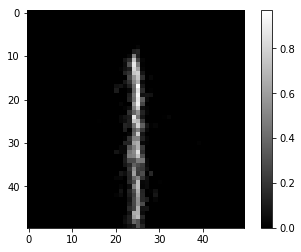

In [8]:
def show_dose(nslice):
    plt.imshow(arr_dose[:,nslice,:], cmap=plt.cm.gray)
    plt.colorbar()
    
interact(show_dose, nslice=(0,len(arr_dose)));

In [9]:
img_resampled_dose = sitk.Resample(img_dose, img_ct, sitk.Transform(), sitk.sitkLinear, 0)

In [10]:
arr_resampled_dose = sitk.GetArrayFromImage(img_resampled_dose)
print('Image size = ', arr_resampled_dose.shape)
print('Image min and max: ',  np.amin(arr_resampled_dose), np.amax(arr_resampled_dose))

('Image size = ', (111, 126, 126))
('Image min and max: ', 0.0, 0.82059324)


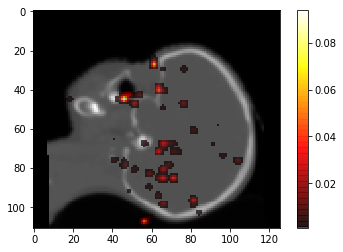

In [11]:
def show_fusion(nslice=50, opacity=0.7):
    plt.imshow(arr_ct[:,:,nslice], cmap=plt.cm.gray)
    a = arr_resampled_dose[:,:,nslice]
    b = np.ma.masked_where(a <= 0.001, a)
    plt.imshow(b, alpha=opacity, cmap=plt.cm.hot)
    plt.colorbar()
    
interact(show_fusion, nslice=(0,len(arr_ct)), opacity=(0,1,0.1));

Questions:
- plot a depth dose profile
- display uncertainty map
- create another simulation with a different beam angle, merge the two dose maps 


# Exercice : phase-space analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uproot

In [5]:
# Check if this is a root file
try:
    f = uproot.open('../output/output-PhS-g.root')
except Exception:
    print("File '"+filename+"' cannot be opened, not root file ?")
try:
    psf = f['PhaseSpace']
except Exception:
    print("This root file is not a PhaseSpace, keys are: ", f.keys())

In [6]:
print("PhaseSpace keys: ", psf.keys())

PhaseSpace keys:  [b'AtomicNumber', b'Ekine', b'Weight', b'Mass', b'X', b'Y', b'Z', b'dX', b'dY', b'dZ', b'TrackID', b'ParentID', b'EventID', b'RunID']


In [7]:
data = psf.arrays()
E = data[b'Ekine']
print('Number of particles: ', len(E))

Number of particles:  987


Energy min 0.06671856343746185 max 5.621015548706055 mean 1.0617868900299072 std 1.057921051979065


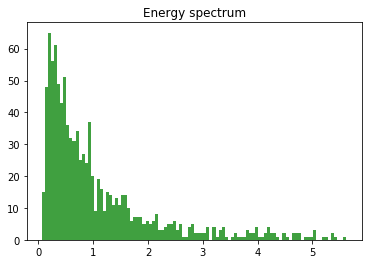

In [8]:
n, bins, patches = plt.hist(E, 100, facecolor='green', alpha=0.75)
plt.title('Energy spectrum')
print('Energy min {} max {} mean {} std {}'.format(np.amin(E), np.amax(E), np.mean(E), np.std(E)))

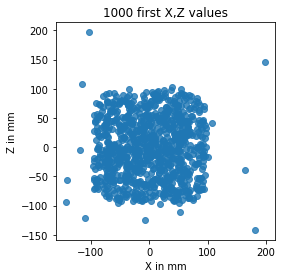

In [19]:
x = data[b'X']
z = data[b'Z']
# print (y)
a = plt.scatter(x[:1000], z[:1000], alpha=0.8)
plt.title('1000 first X,Z values')
plt.xlabel('X in mm')
plt.ylabel('Z in mm')
# gca is "get current axe" to set the aspect such X and Y axes are equal
plt.gca().set_aspect('equal')

Text(0,0.5,'dZ')

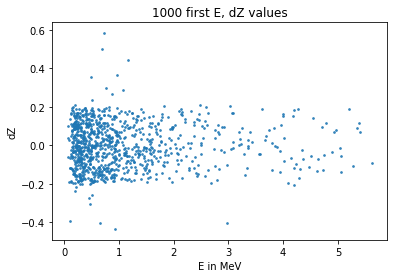

In [20]:
dz = data[b'dZ']
plt.scatter(E[:1000], dz[:1000], alpha=0.8, s=3)
plt.title('1000 first E, dZ values')
plt.xlabel('E in MeV')
plt.ylabel('dZ')